In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import gaussian_kde
import os
import matplotlib.cm as cm

sns.set_context("talk")
os.chdir("../..")

In [2]:
# Set up output dir
output_dir = "comparisonOutputs/L1BQC/Rrs/"

# Read in mySAS data

In [3]:
Es_file = pd.read_csv('comparisonOutputs/L1BQC/ES/mySAS_pySAS_Es_converted.csv')
Li_file = pd.read_csv('comparisonOutputs/L1BQC/LI/mySAS_pySAS_Li_converted.csv')
Lt_file = pd.read_csv('comparisonOutputs/L1BQC/LT/mySAS_pySAS_Lt_converted.csv')

In [4]:
Es_file.head()

,Time_UTC_logger,415_converted,445_converted,480_converted,515_converted,555_converted,590_converted,630_converted,680_converted,Time_UTC_rounded,Time_UTC_pySAS,415_pySAS,445_pySAS,480_pySAS,515_pySAS,555_pySAS,590_pySAS,630_pySAS,680_pySAS
0,2025-06-12 16:01:34,78.740085,95.219070,105.616097,98.987175,102.027071,95.904413,92.432491,89.368253,2025-06-12 16:01:34,2025-06-12 16:01:34.459,78.645033,95.232166,105.624214,98.943227,102.044057,96.021807,92.418236,89.311978
1,2025-06-12 16:01:39,78.771059,95.269145,105.635237,99.014924,102.262986,96.132312,92.653777,89.588375,2025-06-12 16:01:39,2025-06-12 16:01:38.899,78.597699,95.053234,105.447925,98.806616,101.926930,95.800218,92.400090,89.383240
2,2025-06-12 16:01:41,78.771059,95.269145,105.654377,99.042673,101.920909,95.818951,92.358729,89.314710,2025-06-12 16:01:41,2025-06-12 16:01:41.225,78.113140,94.749586,105.077745,98.391909,101.520858,95.440469,91.898400,89.134654
3,2025-06-12 16:01:46,78.492290,94.918623,105.252442,98.681937,101.283937,95.211221,91.775338,88.755481,2025-06-12 16:01:46,2025-06-12 16:01:45.607,78.350097,94.562330,104.981955,98.490009,101.472430,95.430521,92.105262,89.084062
4,2025-06-12 16:01:59,78.430342,94.818474,105.118463,98.570941,101.673197,95.610044,92.184382,89.171928,2025-06-12 16:01:59,2025-06-12 16:01:59.152,78.274534,94.586936,104.999638,98.480379,101.414977,95.478765,92.099028,89.249964


# Define Rrs function

In [5]:
def convertRrs(Es, Li, Lt, p=0.028):
    return (Lt - (p * Li)) / Es

# Apply Function

In [6]:
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

# Compute mySAS Rrs
Rrs_df = pd.DataFrame()
Rrs_df["Time"] = Es_file["Time_UTC_logger"]
for wl in wavelengths:
    Rrs_df[f"{wl}_my_Rrs"] = convertRrs(
        Es_file[f"{wl}_converted"],
        Li_file[f"{wl}_converted"],
        Lt_file[f"{wl}_converted"]
    )

# Compute pySAS Rrs
Rrs_py_df = pd.DataFrame()
Rrs_py_df["Time"] = Es_file["Time_UTC_logger"]
for wl in wavelengths:
    Rrs_py_df[f"{wl}_py_Rrs"] = convertRrs(
        Es_file[f"{wl}_pySAS"],
        Li_file[f"{wl}_pySAS"],
        Lt_file[f"{wl}_pySAS"]
    )


In [7]:
# Define wavelength base list (same for both)
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

# Rrs columns (already computed earlier in your script)
rrs_my_cols = [f"{wl}_my_Rrs" for wl in wavelengths]
rrs_py_cols = [f"{wl}_py_Rrs" for wl in wavelengths]

# Sample 10 random rows
subset_my = Rrs_df.sample(n=10, random_state=42)
subset_py = Rrs_py_df.loc[subset_my.index]  # match indices for fair comparison

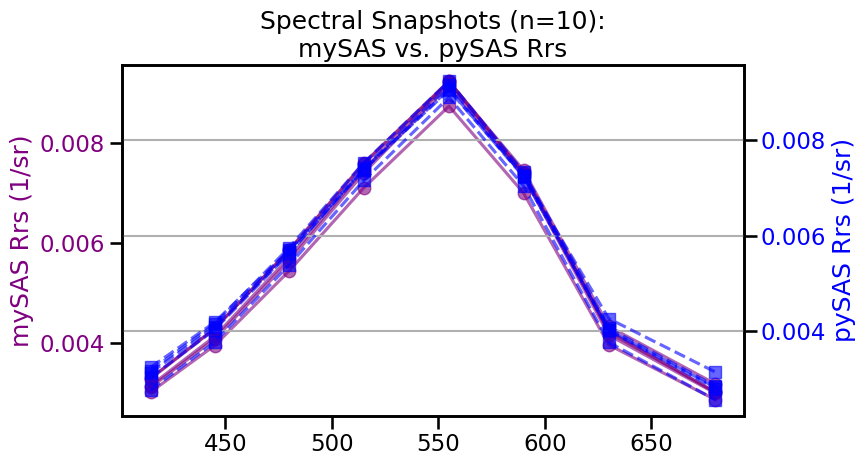

In [8]:
# Plotting
fig, ax1 = plt.subplots(figsize=(9, 5))

# mySAS Rrs (left axis)
for _, row in subset_my.iterrows():
    ax1.plot(wavelengths, row[rrs_my_cols].values, color='purple', alpha=0.6, marker='o', linestyle='-')
ax1.set_ylabel("mySAS Rrs (1/sr)", color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# pySAS Rrs (right axis)
ax2 = ax1.twinx()
for _, row in subset_py.iterrows():
    ax2.plot(wavelengths, row[rrs_py_cols].values, color='blue', alpha=0.6, marker='s', linestyle='--')
ax2.set_ylabel("pySAS Rrs (1/sr)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Labels and aesthetics
plt.xlabel("Wavelength (nm)")
plt.title("Spectral Snapshots (n=10):\nmySAS vs. pySAS Rrs")
plt.grid(True)
fig.tight_layout()
plt.savefig(os.path.join(output_dir, "mySAS_vs_pySAS_Rrs_spectra_multi.png"), dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Prep
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
regression_results = []

for wl in wavelengths:
    my_col = f"{wl}_my_Rrs"
    py_col = f"{wl}_py_Rrs"

    # Drop NaNs
    valid = pd.concat([Rrs_df[my_col], Rrs_py_df[py_col]], axis=1).dropna()
    valid.columns = ['my', 'py']

    x = valid['my'].values.reshape(-1, 1)
    y = valid['py'].values

    model = LinearRegression().fit(x, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(x, y)

    # RMSE
    y_pred = model.predict(x)
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))

    valid['pred'] = y_pred
    regression_results.append({
        'Wavelength': wl,
        'Slope': slope,
        'Intercept': intercept,
        'R²': r2,
        'RMSE': rmse,
        'data': valid
    })


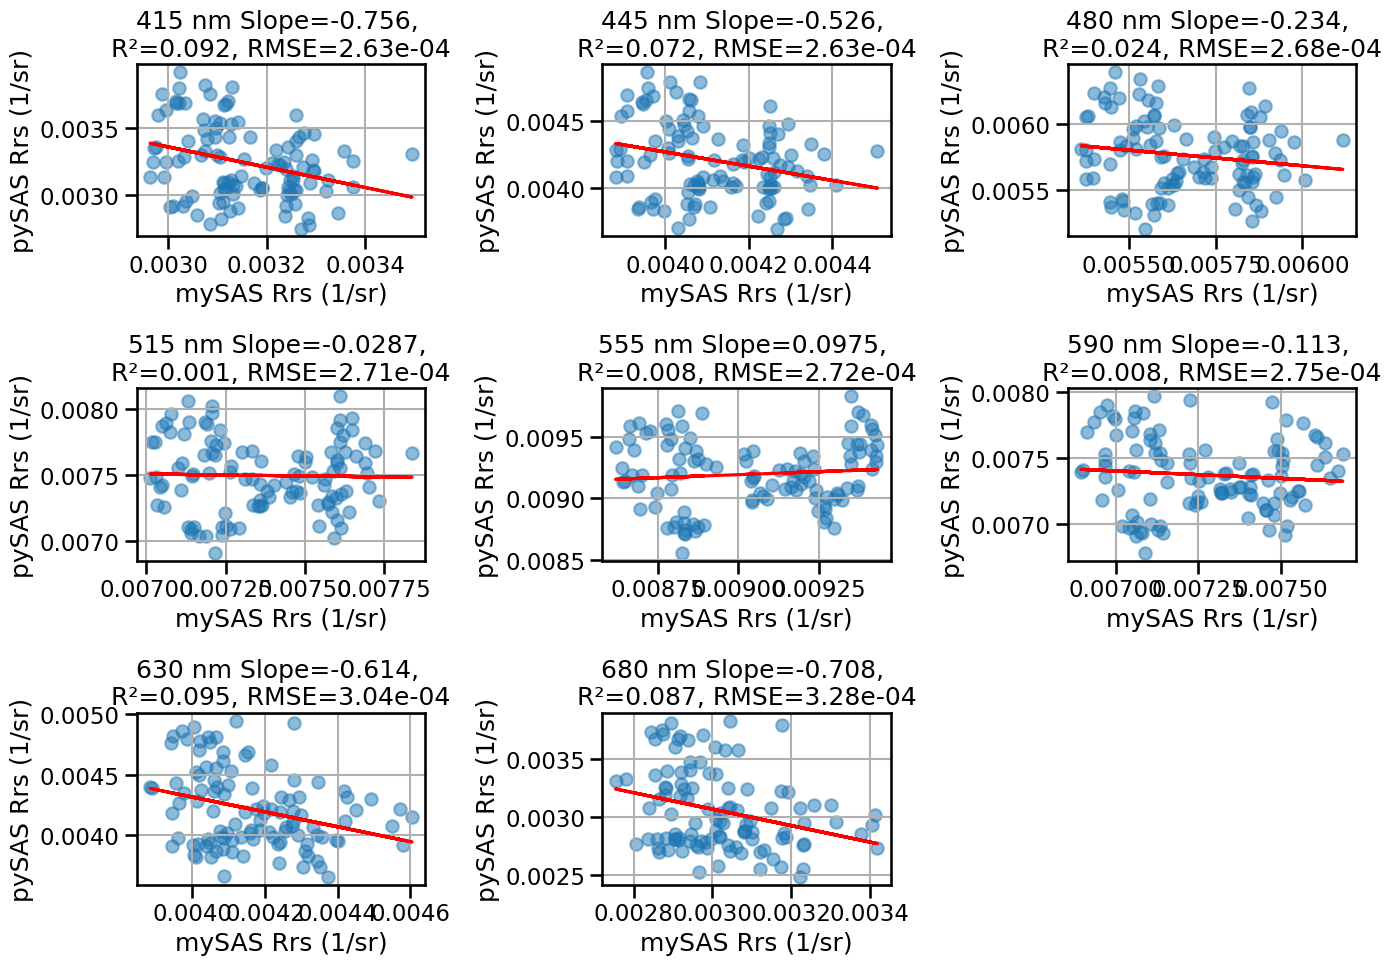

In [10]:
# Plot
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for i, res in enumerate(regression_results):
    ax = axes[i]
    data = res['data']
    wl = res['Wavelength']

    ax.scatter(data['my'], data['py'], alpha=0.5, label='Data')
    ax.plot(data['my'], data['pred'], color='red', label='Fit')

    ax.set_title(
        f"{wl} nm Slope={res['Slope']:.3g}, \nR²={res['R²']:.3f}, RMSE={res['RMSE']:.2e}"
    )
    ax.set_xlabel("mySAS Rrs (1/sr)")
    ax.set_ylabel("pySAS Rrs (1/sr)")
    ax.grid(True)

# Remove unused subplot if any
if len(wavelengths) < len(axes):
    for j in range(len(wavelengths), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

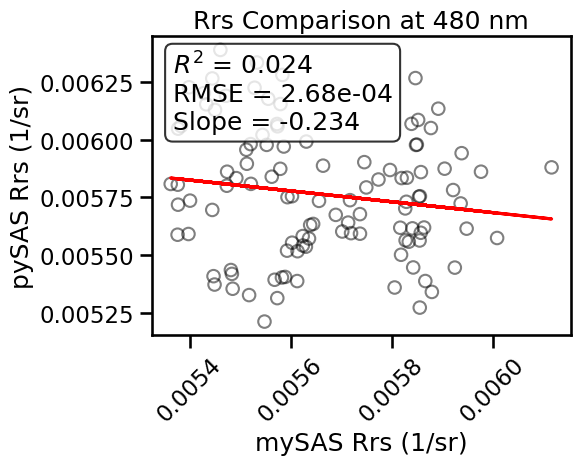

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Choose wavelength
wl = 480
x = Rrs_df[f'{wl}_my_Rrs'].values.reshape(-1, 1)
y = Rrs_py_df[f'{wl}_py_Rrs'].values

# Drop NaNs
mask = ~np.isnan(x.flatten()) & ~np.isnan(y)
x = x[mask]
y = y[mask]

# Fit regression
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)

# Stats
slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(x, y)
rmse = np.sqrt(np.mean((y - y_pred) ** 2))

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(x, y, alpha=0.5, label='Data', edgecolor='k', facecolor='none')
plt.plot(x, y_pred, color='red', label='Fit')

# Stats box
plt.title(f"Rrs Comparison at {wl} nm")
plt.xlabel("mySAS Rrs (1/sr)")
plt.ylabel("pySAS Rrs (1/sr)")
plt.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\nRMSE = {rmse:.2e}\nSlope = {slope:.3g}",
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"mySAS_vs_pySAS_Rrs_regression_{wl}nm.png"), dpi=300, bbox_inches='tight')
plt.show()
